In [101]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns

algorithm = 'lstm' # 'lstm' or 'bilstm'
nrOfSamples = 1000 # 100 or 1000

In [102]:
# Load model and training history

if nrOfSamples == 100:
    history = np.load('models/history_' + algorithm + '.npy',allow_pickle='TRUE').item()
    model = tf.keras.models.load_model('models/model_' + algorithm + '.keras')
elif nrOfSamples == 1000:
    history = np.load('models/history_' + algorithm + '_1000.npy',allow_pickle='TRUE').item()
    model = tf.keras.models.load_model('models/model_' + algorithm + '_1000.keras')

In [103]:
#Load data and extract the training set

if nrOfSamples == 100:
    df = pd.read_csv('Data_Latest.csv')
elif nrOfSamples == 1000:
    df = pd.read_csv('dataCompressed3_125_1000.csv')
    df = df.drop('series_id', axis=1)

df.isna().sum()
features = list(df.columns)
print(features)
print(df)
features.remove("target")
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.head()
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(0, len(data) - seq_length, round(seq_length/2)):
        x = data[i:i+seq_length][['x_0', 'x_1']].values
        y0 = data.iloc[i]['target']
        y = data.iloc[i+seq_length]['target']
        #xs.append(x)
        #ys.append(y)
        if y0 == y:
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 20
x_data, y_data = create_sequences(df, SEQ_LENGTH)
print(len(y_data))




# Placeholder lists for the final training and test sets
x_train_list, x_test_list = [], []
y_train_list, y_test_list = [], []
for label in df['target'].unique():
    x_data_class, y_data_class = create_sequences(df[df['target'] == label], SEQ_LENGTH)
    train_size = int(len(x_data_class) * 0.8)

    # Split the data for this class
    x_train_class, x_test_class = x_data_class[:train_size], x_data_class[train_size:]
    y_train_class, y_test_class = y_data_class[:train_size], y_data_class[train_size:]

    # Append to the final lists
    x_train_list.append(x_train_class)
    x_test_list.append(x_test_class)
    y_train_list.append(y_train_class)
    y_test_list.append(y_test_class)

# Concatenate data from all classes to get the final training and test sets
x_train = np.concatenate(x_train_list, axis=0)
x_test = np.concatenate(x_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

['x_0', 'x_1', 'target']
              x_0        x_1  target
0        0.367913  -0.073622       0
1        0.156383   0.192457       0
2       -0.159244   0.634766       0
3       -0.438949   1.160518       0
4       -0.859950   1.773462       0
...           ...        ...     ...
460190  18.647719  17.940213       9
460191  18.702322  18.524317       9
460192  18.919173  19.075808       9
460193  19.286674  19.540489       9
460194  19.803250  19.755031       9

[460195 rows x 3 columns]
46000


In [104]:
len(y_test)

9207

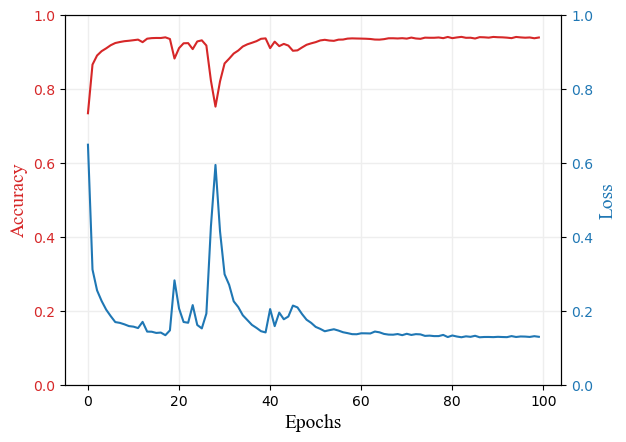

In [105]:
import matplotlib.pyplot as plt

font_style = {'family' : 'Times New Roman', # 'Times New Roman'
        'weight' : 'normal',
        'size'   : 14}

font_style_nr = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

fig, ax0 = plt.subplots()
color='tab:red'
ax0.set_ylabel('Accuracy', **font_style, color=color)
plt.xlabel('Epochs', **font_style)
plt.plot(history['accuracy'], color=color)
ax0.tick_params(axis='y', labelcolor=color)
plt.ylim([0, 1])
#plt.plot(history['val_accuracy'])


plt.grid(color='#eeeeee', linestyle='-', linewidth=1)
color='tab:blue'

ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_ylabel('Loss', **font_style, color=color)
plt.plot(history['loss'], color=color)

plt.ylim([0, 1])
ax1.tick_params(axis='y', labelcolor=color)
#plt.plot(history['val_loss'])
plt.title('')
#plt.ylabel('Accuracy', **font_style)
plt.show()


image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'accuracy_'+algorithm+str(nrOfSamples)+'.pdf'
fig.savefig(image_name, format=image_format, dpi=1200)

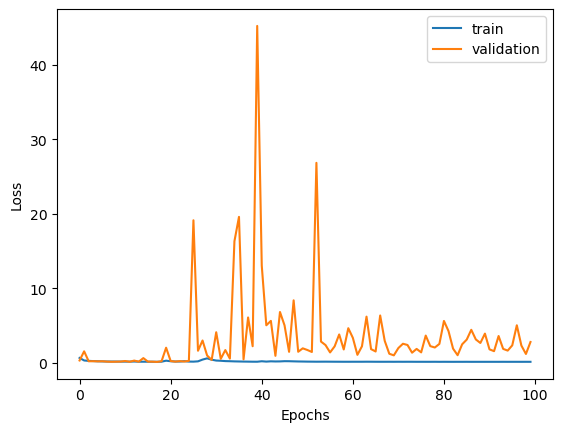

In [106]:
fig, ax = plt.subplots()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'loss_'+algorithm+str(nrOfSamples)+'.pdf'

fig.savefig(image_name, format=image_format, dpi=1200)

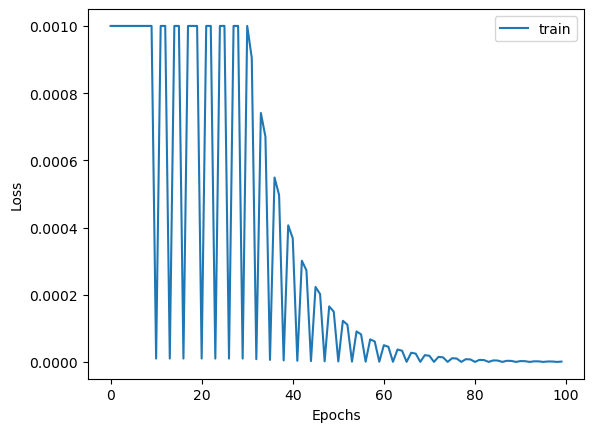

In [107]:

plt.plot(history['lr'])
plt.title('')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [108]:
predictions = model.predict(x_test)
classes_x=np.argmax(predictions,axis=1)

print(x_test[1].shape)
print(predictions.shape)
print(classes_x)

cm = tf.math.confusion_matrix(labels=y_test, predictions=classes_x, num_classes=10)
cm

288/288 [==============================] - 10s 34ms/step
(20, 2)
(9207, 10)
[0 0 0 ... 9 9 9]


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 846,   13,    2,    3,    4,    1,    0,   17,   35,    6],
       [   8,  745,    0,    0,   74,    0,    1,   24,    1,    0],
       [   0,    0,  696,    1,    0,    0,    0,    0,   25,    0],
       [   0,    0,    0,  645,    0,    0,    0,    0,    0,    3],
       [   0,   53,    0,    0,  944,    0,    0,   51,    0,    0],
       [   0,    0,    0,    0,    0,  829,    6,    6,    0,    0],
       [   0,    0,    0,    2,    0,   31,  877,   56,    0,    0],
       [   0,    5,    0,    0,   36,   26,   62, 1408,    0,    0],
       [   0,    0,    0,    0,    3,    0,    0,    0,  916,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  746]])>

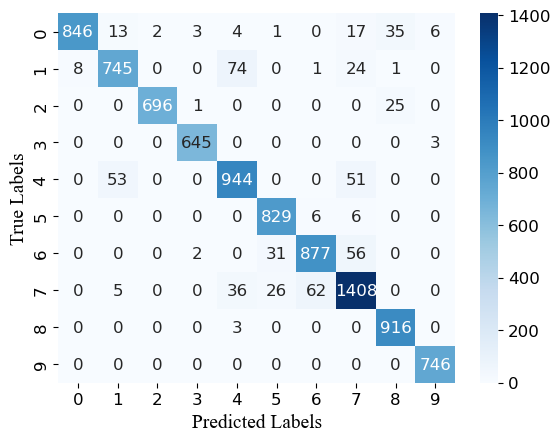

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

font_style = {'family' : 'Times New Roman', # 'Times New Roman'
        'weight' : 'normal',
        'size'   : 14}

font_style_nr = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

hm = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', annot_kws={'fontdict': font_style_nr})
hm.set_xticklabels(hm.get_xticklabels(), fontdict=font_style_nr)
hm.set_yticklabels(hm.get_yticklabels(), fontdict=font_style_nr)
cbar = hm.collections[0].colorbar
# Set font style for colorbar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('sans-serif')
    label.set_fontweight('normal')



plt.xlabel('Predicted Labels', fontdict=font_style)
plt.ylabel('True Labels', fontdict=font_style)
plt.show()


image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'confusion_'+algorithm+str(nrOfSamples)+'.pdf'

fig.savefig(image_name, format=image_format, dpi=1200)

In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_x, digits=4))

              precision    recall  f1-score   support

         0.0     0.9906    0.9126    0.9500       927
         1.0     0.9130    0.8734    0.8928       853
         2.0     0.9971    0.9640    0.9803       722
         3.0     0.9908    0.9954    0.9931       648
         4.0     0.8897    0.9008    0.8952      1048
         5.0     0.9346    0.9857    0.9595       841
         6.0     0.9271    0.9079    0.9174       966
         7.0     0.9014    0.9161    0.9087      1537
         8.0     0.9376    0.9967    0.9662       919
         9.0     0.9881    1.0000    0.9940       746

    accuracy                         0.9397      9207
   macro avg     0.9470    0.9453    0.9457      9207
weighted avg     0.9403    0.9397    0.9396      9207

